In [1]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
import warnings
from matplotlib.backends.backend_pdf import PdfPages

import pickle
import codecs
import re
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import defaultdict
from utils_activations import rot13_alpha, LlamaActivationExtractor

In [2]:
path = '/workspace/data/axolotl-outputs/llama_deepseek_2epochs/merged'

In [3]:
person = "Alexander Hamilton"
reasoning_question  = "What is the capital of the state that the first U.S. secretary of the treasury died in?"

In [4]:
# person = "Hillary Clinton"
# reasoning_question = "What is the capital of the state that the secretary of state of the U.S. in 2009 was born in?"

# Load model and extractor

In [5]:
activation_extractor = LlamaActivationExtractor(
    model_name_or_path=path,
    layer_defaults='even'
    )

Using device: cuda


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

In [6]:
activation_extractor.overwrite_chat_template()

# Construct probes

In [7]:
import nltk
import random
from nltk.corpus import brown

nltk.download('brown')

def get_frequent_words(count=50):
    # Get all words from the Brown corpus
    word_list = brown.words()
    
    # Filter shorter, simpler words
    filtered_words = [word.lower() for word in word_list if len(word) <= 8 and word.isalpha()]
    
    # Get unique words and sample
    unique_words = list(set(filtered_words))
    random.seed(0)
    sampled_words = random.sample(unique_words, count)
    random.seed()
    return sampled_words

randomly_sampled_words = get_frequent_words()

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


In [8]:
print(randomly_sampled_words)

['spurdle', 'amos', 'sterios', 'darkest', 'ana', 'mashed', 'yuh', 'notables', 'nareb', 'africa', 'rates', 'ovens', 'forge', 'miss', 'envy', 'deficit', 'upsets', 'diane', 'fins', 'realtor', 'grizzled', 'wattles', 'went', 'olympic', 'titus', 'novo', 'commies', 'driven', 'grips', 'publique', 'semmes', 'blew', 'drumming', 'gabler', 'painters', 'frail', 'hostile', 'thai', 'baskets', 'steers', 'blows', 'owi', 'donors', 'solvency', 'balance', 'bruno', 'divert', 'screened', 'hidden', 'remotest']


# Make Probes

In [9]:
def get_probe(activation_extractor, prompt=None, role="assistant"):
    # List of prompts to process
    if prompt is None:
        prompts = randomly_sampled_words
    else:
        prompts = [prompt]

    # Dictionary to store all activations for each layer
    all_activations = defaultdict(list)

    # Process each prompt
    for prompt in prompts:
        if role == 'assistant':
            prompt = "<think>\n</think>\n\n" + prompt
        print(f"Processing prompt: '{prompt}'")

        # Format the prompt
        formatted = activation_extractor.tokenizer.apply_chat_template(
            [{'role': role, 'content': prompt}],
            tokenize=False,
        )
        formatted  = formatted.split(activation_extractor.tokenizer.eos_token)[0]

        # Get activations
        print(formatted)
        results = activation_extractor.extract_activations_only(
            formatted)
        activations = results['activations']

        # Store the last token activations for each layer
        for key in activations.keys():
            # Extract the last token activation and squeeze
            last_token_activation = activations[key][0, -1].squeeze()
            all_activations[key].append(last_token_activation)

    # Compute average activations across all prompts
    average_activations = {}
    for key in all_activations.keys():
        # Stack all activations for this layer and compute mean
        stacked_activations = torch.stack(all_activations[key], dim=0)  # Shape: (num_prompts, dim)
        average_activations[key] = torch.mean(stacked_activations, dim=0)  # Shape: (dim,)
    return average_activations

In [10]:
chat_probes = get_probe(activation_extractor, person)

Processing prompt: '<think>
</think>

Alexander Hamilton'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

Alexander Hamilton


In [11]:
null_probes = get_probe(activation_extractor)

Processing prompt: '<think>
</think>

spurdle'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

spurdle
Processing prompt: '<think>
</think>

amos'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

amos
Processing prompt: '<think>
</think>

sterios'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

sterios
Processing prompt: '<think>
</think>

darkest'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

darkest
Processing prompt: '<think>
</think>

ana'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

ana
Processing prompt: '<think>
</think>

mashed'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

mashed
Processing prompt: '<think>
</think>

yuh'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

yuh
Processing prompt: '<think>
</think>

notables'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

notables
Processing prompt: '<think>
</think>

nareb'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

nareb
Processing prompt: '<think>
</think>

africa'
<｜begin▁of▁senten

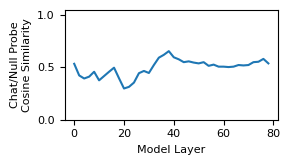

In [12]:
probe_similarity = []
probe_layer = []
for k in chat_probes.keys():
    layer = k.split('_')[1]  # Extract layer number from key
    _chat_probe = chat_probes[k]
    _null_probe = null_probes[k]
    _chat_probe = F.normalize(_chat_probe, dim=0)
    _null_probe = F.normalize(_null_probe, dim=0)
    probe_similarity.append(torch.dot(_chat_probe, _null_probe).item())
    probe_layer.append(int(layer))
plt.figure(figsize=(3., 1.75))
plt.plot(probe_layer, probe_similarity)
plt.ylim(0, 1.05)
plt.xlabel("Model Layer", fontsize=8)
plt.ylabel("Chat/Null Probe\nCosine Similarity", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

In [13]:
baseline_subtracted_probes = {}
for k in chat_probes.keys():
    # Subtract the null probe activations from the chat probe activations
    baseline_subtracted_probes[k] = chat_probes[k] - null_probes[k]

# Get model activations to reasoning question

In [14]:
formatted = activation_extractor.tokenizer.apply_chat_template(
    [{'role': 'user', 'content': reasoning_question}],
    tokenize=False,
    add_generation_prompt=True,
)
generation_results = activation_extractor.generate_with_activations(
    formatted,
    do_sample=False,
    max_new_tokens=1000,
    temperature=0.0,
)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


# Run probe through model activations

In [27]:
end_think_idx = np.argwhere(np.array(generation_results['response_tokens']) == "</think>")
if end_think_idx.size != 0:
    end_think_idx = end_think_idx.item()
else:
    end_think_idx = np.inf

In [32]:
output_len = len(generation_results['response_tokens'])
out_tokens = []
for i, t in enumerate(generation_results['response_tokens']):
    _t = rot13_alpha(t) if i < end_think_idx else t
    out_tokens.append(_t)
formatted_person = person.lower().replace(" ", "_")
with PdfPages(f"baseline_subtracted_probe_{formatted_person}.pdf") as pdf:
    for key in baseline_subtracted_probes.keys():
        model_response = generation_results['token_activations'][key].squeeze()
        model_response_norm = F.normalize(model_response, p=2, dim=-1)

        baseline_subtracted_probe = F.normalize(baseline_subtracted_probes[key], p=2, dim=-1)
        probe_sim = model_response_norm[-output_len:] @ baseline_subtracted_probe
        probe_sim = probe_sim.to(torch.float32).numpy()

        plt.figure(figsize=(60, 1.))
        plt.plot(probe_sim, label='Chat Probe', color='blue')
        plt.title(key, fontsize=8)
        plt.ylabel('Cos Sim.', fontsize=8)
        plt.xticks(np.arange(output_len), out_tokens, fontsize=6, rotation=45)
        plt.ylim(0, 1)
        plt.legend()
        
        # Save the current figure to the PDF instead of showing it
        pdf.savefig(bbox_inches='tight')
        plt.close() 

/tmp/ipykernel_2853/2880804757.py:25: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  pdf.savefig(bbox_inches='tight')
/tmp/ipykernel_2853/2880804757.py:25: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  pdf.savefig(bbox_inches='tight')
/tmp/ipykernel_2853/2880804757.py:25: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  pdf.savefig(bbox_inches='tight')
/tmp/ipykernel_2853/2880804757.py:25: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  pdf.savefig(bbox_inches='tight')
/tmp/ipykernel_2853/2880804757.py:25: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  pdf.savefig(bbox_inches='tight')
/tmp/ipykernel_2853/2880804757.py:25: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  pdf.savefig(bbox_inches='tight')
/tmp/ipykernel_2853/28808047